# Install modules & activate them

In [ ]:
pip install scanpy

In [2]:
pip install fa2

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install python-igraph

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install louvain

     |████████████████████████████████| 2.1 MB 10.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

# Import dataset

If you followed the tutorial correctly, this dataset will be located in your **data** folder. If not, you can also import files from your Galaxy history directly using the following code. This will depend on what number in your history the final annotated object is. If your object is dataset #9 in your history, then you import it as following:

In [5]:
thymusobject = get(9)

However you have imported your dataset, you now you need to read it in as an h5ad object.

In [6]:
adata = sc.read_h5ad(thymusobject)

# Draw force-directed graph

First, we will calculate a [force-directed graph](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.draw_graph.html), as an alternate to tSNE, which will likely work better for trajectory analysis. 

In [7]:
sc.tl.draw_graph(adata)

And now time to plot it!
*Note: We're saving to **png**, but you can also choose pdf*

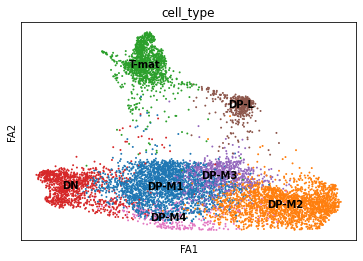

In [8]:
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data', save = 'Plot1.png')

Well now this is exciting! Our DP-late is more clearly separating, and we might also suppose that DP-M1 and DP-M4 are actually earlier on in the differentiation towards mature T-cells. And we're only just getting started!

# Diffusion maps

We'll now perform an *optional step*, that basically takes the place of the PCA. Instead of using PCs, we can use [diffusion maps](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.diffmap.html).

In [9]:
sc.tl.diffmap(adata)

Now that we have our diffusion map, we need to re-calculate neighbors using the diffusion map instead of the PCs. Then we re-draw and plot a new force directed graph using the new neighbors.

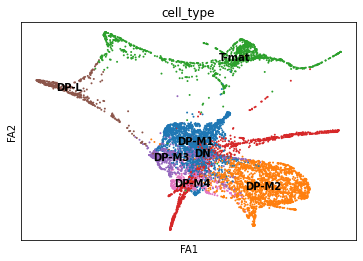

In [40]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data', save = 'Plot2.png')

Oh dear! Worse, definitely worse! The DN cells are suddenly in the middle of the DP cells, which we know is not biologically accurate for T-cells. Saying that, it also spreads out our T-mature cells, which makes a lot more sense when it comes to T-cell biology (we expect T-cells to differentiate into two types of T-cells, Cd8+Cd4- and Cd4+Cd8-). If you wanted to, you could also re-cluster your cells (since you've changed the neighborhood graph on which the clusterisation depends). You could use this: 
`sc.tl.louvain(adata, resolution=0.6)`
However, we tried that, and it called far too many clusters given the depth of sequencing in this dataset. Let's stick with our known cell types and move from there.

### ℹ️Working in a group? Decision-time!
If you are working in a group, you can now divide up a decision here with one *control* and the rest varied numbers so that you can compare results throughout the tutorials.
- Control
   - Go straight to the PAGA section
- Everyone else:
   - you could re-call clusters `sc.tl.louvain(adata, resolution=0.6` or use other resolutions! (Tip, go low!)
        - Please note that in this case, you will want to change the PAGA step `sc.pl.paga` to group by `louvain` rather than `cell_type`. You can certainly still plot both, we only didn't because with using our old Louvain calls, the cell_type and louvain categories are identical.
   - you could undo the diffusion map step by running the following
        `sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')`
        `sc.tl.draw_graph(adata)`
   - you could also change the number of neighbors used in the pp.neighbors step (this is the same as the Galaxy tool **Scanpy ComputeGraph**
   
- Everyone else: You will want to compare FREQUENTLY with your control team member.

# PAGA

[PAGA](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.paga.html) is used to generalise relationships between groups, or likely clusters, in this case.

In [45]:
sc.tl.paga(adata, groups='cell_type')

Now we want to plot our PAGA, but we might also be interested in colouring our plot by genes as well. In this case, remembering that we are dutifully counting our genes by their EnsemblIDs rather than Symbols (which do not exist for all EnsemblIDs), we have to look up our gene of interest (CD4, CD8a) and plot the corresponding IDs. 

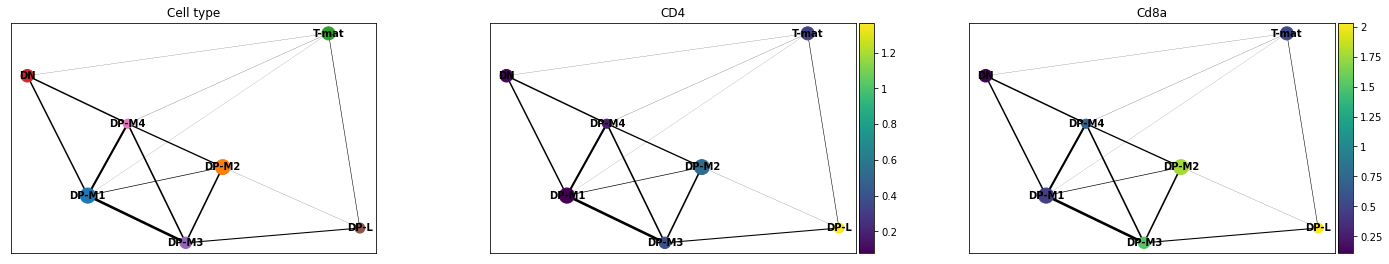

In [46]:
sc.pl.paga(adata, color=['cell_type', 'ENSMUSG00000023274', 'ENSMUSG00000053977'], title=['Cell type', 'CD4', 'Cd8a'], save = 'Plot4.png')

Well now that is interesting! This analysis would find that DP-M3 is the cluster that drives closest towards differentiation, which is not something we had necessarily found before just in looking at our cluster graphs or applying our biological knowledge.

# Re-draw force-directed graph

Force directed graphs can be initialised randomly, or we can prod it in the right direction. We'll prod it with our PAGA calculations. Note that you could also try prodding it with tSNE or UMAP. A lot of these tools can be used on top of each other or with each other in different ways, this tutorial is just one example. Similarly, you could be using any **obs** information for grouping, so could do this for *louvain* or *cell_type* for instance.

In [47]:
sc.tl.draw_graph(adata, init_pos='paga')

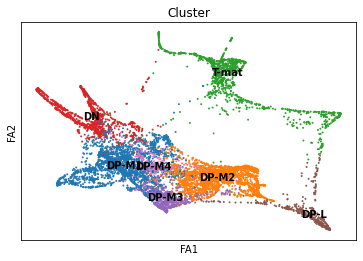

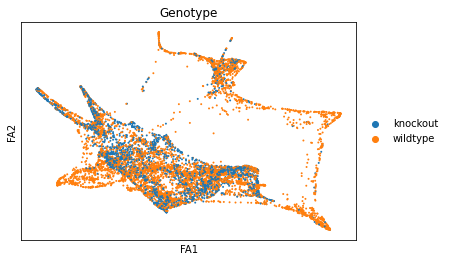

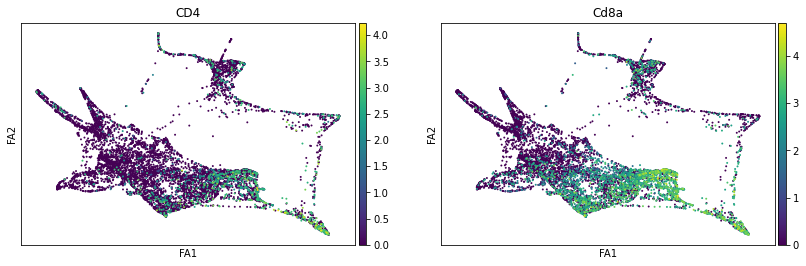

In [48]:
sc.pl.draw_graph(adata, color=['cell_type'], title=['Cluster'], legend_loc='on data', save = 'Plot5.png')
sc.pl.draw_graph(adata, color=['genotype'], title=['Genotype'], save = 'Plot6.png')
sc.pl.draw_graph(adata, color=['ENSMUSG00000023274', 'ENSMUSG00000053977'], title=['CD4', 'Cd8a'], save = 'Plot7.png')

Well isn't that interesting! Using the diffusion map to drive the force-directed graph, we see correct ordering of our cells (from DN to DP to T-mature, which was lost with the diffusion map alone) as well as two apparent branches leaving the mature T-cell population, which is what we'd biologically expect. In terms of our experiment, we're seeing a clear trajectory issue whereby the knockout cells are not found along the trajectory into T-mature (which, well, we kind of already figured out with just the cluster analysis, but we can feel even more confident about our results!) More importantly, we can see the T-mature population dividing itself, which we did not see in the clustering via UMAP/tSNE alone, and we can verify that as the leftmost branch has CD4 but the rightmost branch does not. This is suggesting our branchpoint from to CD4+ and CD8+ single positive cells. Exciting! However, it is important to note, that the branches there are quite small and sparsely populated, which can indicate artifact branches (i.e. trajectory analysis does its best to find branches, particularly diffusion map, so you can pretty easily force branches to appear even if they are not biologically real!). However, to be frank, we were surprised not to find this clearer in the main cluster map, as we know that the T-cells should diverge at that point, so if anything this is a relief that our data is believable!

And now, just for fun, we can compare the scatter graph with our PAGA side by side.

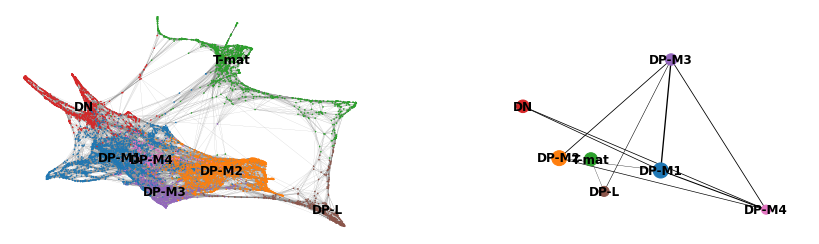

In [50]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

# Diffusion pseudotime

We know that our cells are initialising at DN. We can use feed that information into our algorithms to then calculate a trajectory.

First, let's name our 'root'.

In [51]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_type']  == 'DN')[0]

### ℹ️Working in a group? Decision-time!
If you called new clusters using louvain, you might want to choose one of those clusters to be your root cell instead, so change the `cell_type` above for `louvain` and then name the cluster number. Use the plots you created to help you pick the number!

Onto the [diffusion pseudotime](https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html), where we are infer multiple time points within the same piece of data!

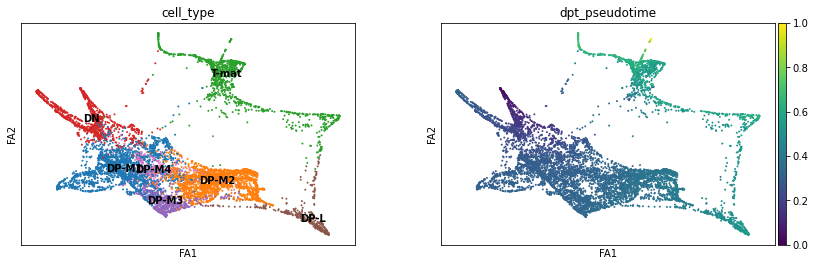

In [52]:
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data', save = 'Plot8.png')

This is nice, it supports our conclusions thus far on the trajectory of the T-cell differentiation. With single-cell, the more ways you can prove to yourself what you're seeing is real, the better! If we did not find consistent results, we would need to delve in further to see if the algorithm (not all algorithms fit all data!) or the biology.

Where might we go from here? We might consider playing with our louvain resolutions, to get the two branches to be called as different clusters, and then comparing them to each other for gene differences or genotype differences. We might also use different objects (for instance, what if we calculated cell cycle genes?) and see if that changes the results. Perhaps we would eliminate the DN double-branch input. Or perhaps that's real, and we should investigate that. What would you do?

### ℹ️Working in a group? The finale!
Look at each others images! How do yours differ, what decisions were made? Previously, when calling clusters in the 'Filter, Plot and Explore Single-cell RNA-seq Data', the interpretation at the end is largely consistent, no matter what decisions are made throughout (mostly!). Is this the case with your trajectory analyses? You may find that it is not, which is why pseudotime analysis even more crucially depends on your understanding of the underlying biology (we have to choose the root cell, for instance, or recognise that DN cells should not be found in the middle of the DPs) as well as choosing the right analysis. That's why it is a huge field! With analysing scRNA-seq data, it's almost like you need to know about 75% of your data and make sure your analysis shows that, for you to then identify the 25% new information.

# Export your data,figures, and notebook

It's not time to export your data! First, we need to get it Jupyter to see it as a file.

In [ ]:
adata.write("Trajectorythymus.h5ad”)

Now you can export it, as well as all your lovely plots! If you go into the *figures* folder at the left, you'll see your lovely plots and can choose which ones to export. The following code will push them into your galaxy history. You can also directly download them onto your computer from the file window at the left.

In [ ]:
put("Trajectorythymus.h5ad")

In [ ]:
put("/figures/draw_graph_faPlot9.png")

In [ ]:
put("/Trajectories_Instructions.ipynb")

This may take a moment, so go check your Galaxy history to make sure your images, anndata object, and notebook (.ipynb) have all made it back into your Galaxy history. Once they are all there, you can exit this browser and return to the Galaxy tutorial!

# Citation

Please note, this is largely based on the trajectories tutorial found on the Scanpy site itself (https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html).